# 项目：Home Credit信用贷款违约预测
## 一、项目背景：
    比赛由 Kaggle 举办，要求选手依据客户的信用卡信息，分期付款信息，信用局信息，先前贷款情况等预测客户贷款是否会违约。对预测结果的评价指标为AUC。

### 1.定义问题
   1. 什么样的用户更容易违约？
   2. 建立模型预测新客户的还款能力。
    
### 2.数据集
   该项目一共提供了八个数据文件，其中包括一个主训练集，一个测试集，六个辅助信息集。其中辅助训练集包括两个信用局数据集，四个先前贷款情况数据集。


## 二、数据清洗及处理
### 1.缺失值处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
import gc

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score 

In [2]:
#导入数据
train_data=pd.read_csv(r'E:\machine learning\信用风险数据集\application_train.csv')
test_data=pd.read_csv(r'E:\machine learning\信用风险数据集\application_test.csv')

In [3]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_data.columns[:30]

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [5]:
# Check the missing data
def missing_data_table(df):
    total=df.isnull().sum().sort_values(ascending=False)
    percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data_sketch=pd.concat([total,percent],axis=1,keys=['total','percent'])
    #Delete variables that don't have missing data
    missing_data=missing_data_sketch.loc[missing_data_sketch['total']!=0,:]
    
    print('number of features:{}；{} features have missing values'.format(missing_data_sketch.shape[0],missing_data.shape[0]))
    return missing_data

In [6]:
#查看缺失值情况
missing_data_table(train_data).head(30)

number of features:122；67 features have missing values


,total,percent
COMMONAREA_MEDI,214865,0.698723
COMMONAREA_AVG,214865,0.698723
COMMONAREA_MODE,214865,0.698723
NONLIVINGAPARTMENTS_MODE,213514,0.694330
NONLIVINGAPARTMENTS_MEDI,213514,0.694330
NONLIVINGAPARTMENTS_AVG,213514,0.694330
FONDKAPREMONT_MODE,210295,0.683862
LIVINGAPARTMENTS_MEDI,210199,0.683550
LIVINGAPARTMENTS_MODE,210199,0.683550
LIVINGAPARTMENTS_AVG,210199,0.683550


   数据一共有122列，其中有67列存在缺失值，同时，可以看到缺失的数据大部分为房屋信息，对此可在特征工程中创建一个新的特征来说明顾客是否提供了房屋信息。
   
   本项目采用lightgbm算法，lightgbm和xgboost算法本身自己有一套缺失值处理算法，会把含有缺失值的数据分别放到左右两个子节点计算增益，择优录取。因此，本项目不对缺失值进行处理。

### 2.异常值探索

对连续型数据进行异常值探索。

In [7]:
#异常值探索
train_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


我们可以看到DAYS_BIRTH，DAY_EMPLOYED的数据均为负值,这是记录方式不同造成的，我们将这几个特征对应的数据均/-365

In [8]:
train_data['DAYS_BIRTH']=train_data['DAYS_BIRTH']/-365
train_data['DAYS_BIRTH'].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [9]:
(train_data['DAYS_EMPLOYED']/-365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [10]:
train_data['DAYS_REGISTRATION']=train_data['DAYS_REGISTRATION']/-365
train_data['DAYS_REGISTRATION'].describe()

count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

In [11]:
train_data['DAYS_ID_PUBLISH']=train_data['DAYS_ID_PUBLISH']/-365
train_data['DAYS_ID_PUBLISH'].describe()

count    307511.000000
mean          8.203294
std           4.135481
min          -0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: DAYS_ID_PUBLISH, dtype: float64

我们发现DAYS_EMPLOYED的最小值为-1000，这不符合常理，显然是一个异常值

In [12]:
train_data['DAYS_EMPLOYED'].sort_values(ascending=False).head(20)

253780    365243
268773    365243
72056     365243
72057     365243
268782    365243
72066     365243
268780    365243
141251    365243
141250    365243
72079     365243
72083     365243
268775    365243
231791    365243
141245    365243
72050     365243
231796    365243
141232    365243
72099     365243
72100     365243
72105     365243
Name: DAYS_EMPLOYED, dtype: int64

发现异常值基本都是一个数，所以将它替换成空值，这样即可以保留这个特征，又抹去了异常值。

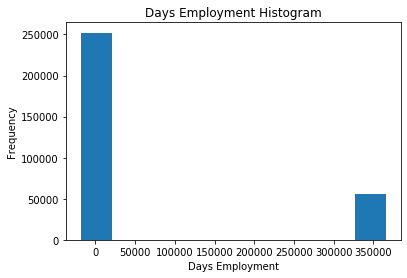

In [13]:
#替换前
train_data['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment');

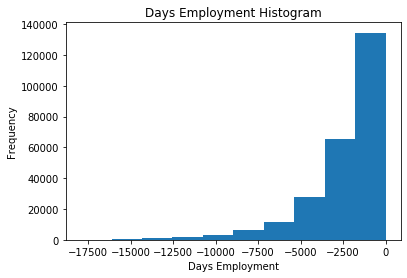

In [14]:
train_data['DAYS_EMPLOYED'].replace({ 365243 : np.nan},inplace=True)
#替换后
train_data['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment');

## 三、数据可视化探索
   分析各特征的违约用户分布，探索违约率差异。

In [15]:
#plot function
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp=train_data[feature].value_counts()
    df1=pd.DataFrame({feature:temp.index,'Number of contracts':temp.values})
    
    #Calculate the percentage of target=1 per category value
    cat_perc=train_data[[feature,'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET',ascending=False,inplace=True)
    
    if (horizontal_layout):
        fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,6))
    else:
        fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,14))
        
    sns.set_color_codes('pastel')
    s=sns.barplot(ax=ax1,x=feature,y='Number of contracts',data=df1)
    if (label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s=sns.barplot(ax=ax2,x=feature,y='TARGET',order=cat_perc[feature],data=cat_perc)
    if (label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 (%)',fontsize=10)
    plt.tick_params(axis='both',which='major',labelsize=10)
    
    plt.show()
    

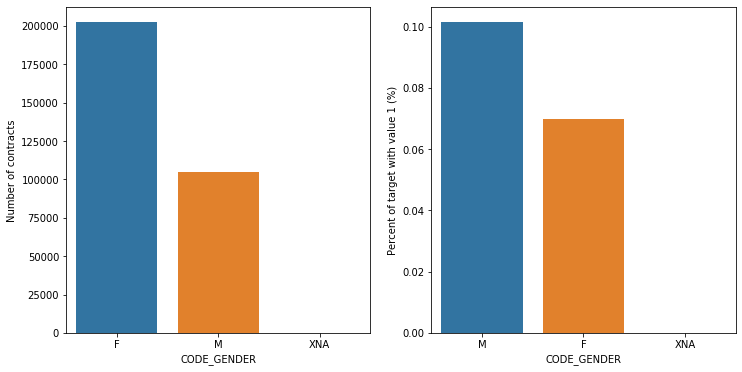

In [16]:
#性别差异
plot_stats('CODE_GENDER')

训练集中女性贷款人数明显高于男性，而女性违约率低于男性，其中男性违约率约为10%，女性违约率约为7%。

Text(0.5, 1.0, 'Distribution of ages')

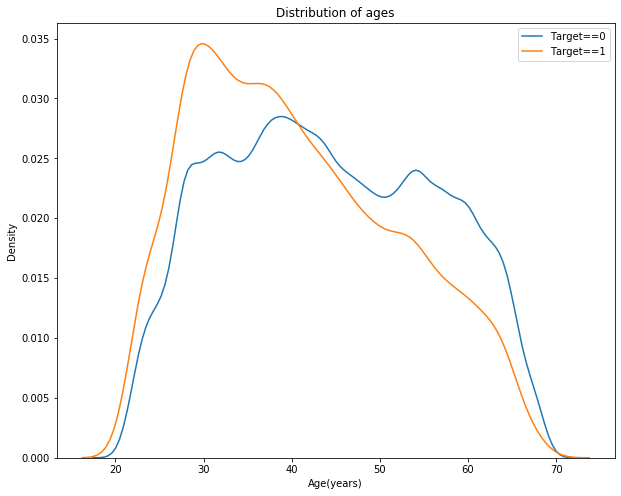

In [17]:
#年龄差异
plt.figure(figsize=(10,8))
sns.kdeplot(train_data.loc[train_data['TARGET']==0,"DAYS_BIRTH"],label='Target==0')
sns.kdeplot(train_data.loc[train_data['TARGET']==1,"DAYS_BIRTH"],label='Target==1')
plt.xlabel('Age(years)')
plt.ylabel('Density')
plt.title('Distribution of ages')

我们可以发现一定的差异，30岁左右的客户违约率相对来说更高一些，且之后随着年龄有递减的趋势。为了方便观察，我们对年龄变量进行分桶操作。

D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


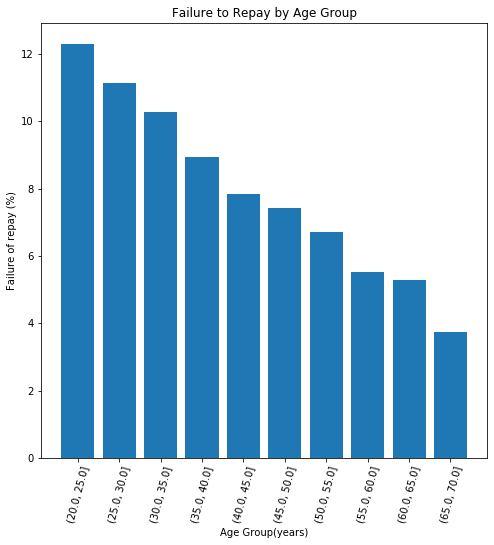

In [18]:
#年龄分桶
age_data=train_data[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BINNED']=pd.cut(age_data['DAYS_BIRTH'],bins=np.linspace(20,70,num=11))
age_groups=age_data.groupby("YEARS_BINNED").mean()
#画图
plt.figure(figsize=(8,8))
plt.bar(age_groups.index.astype(str),100*age_groups['TARGET'])
plt.xticks(rotation=75);plt.xlabel('Age Group(years)');plt.ylabel('Failure of repay (%)')
plt.title('Failure to Repay by Age Group');

从上图可以清晰地看到随着年龄的增加，客户的违约率在降低。因此，可以基本判定年龄是一个重要的影响因素

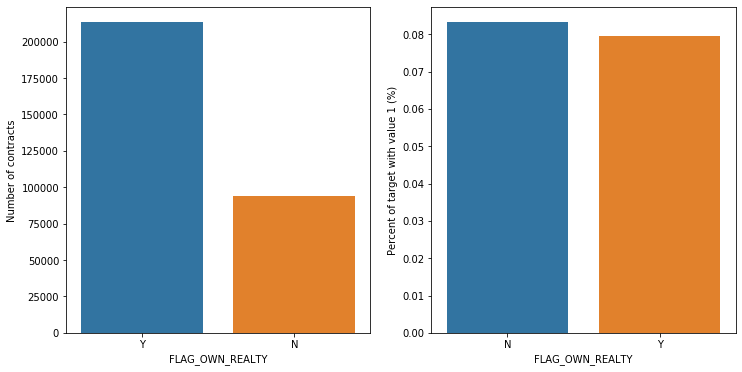

In [19]:
#是否有房
plot_stats('FLAG_OWN_REALTY')

可以看到有房的人更容易贷款，同时有房的客户和没房的客户违约率均在8%左右，区别不明显。

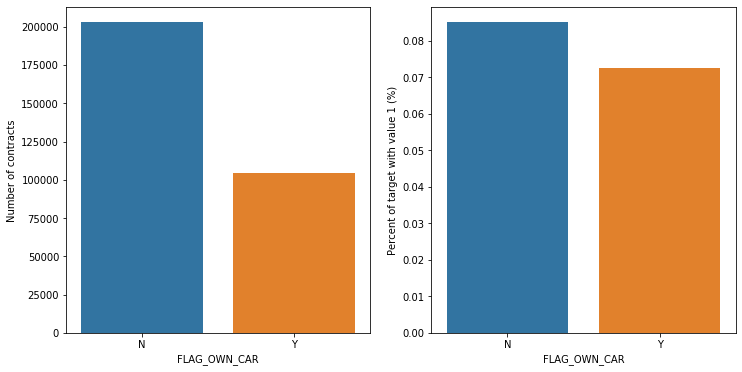

In [20]:
#是否有车
plot_stats('FLAG_OWN_CAR')

没车的人更容易贷款。没车的人贷款违约率略高于有车的人，区别不明显。

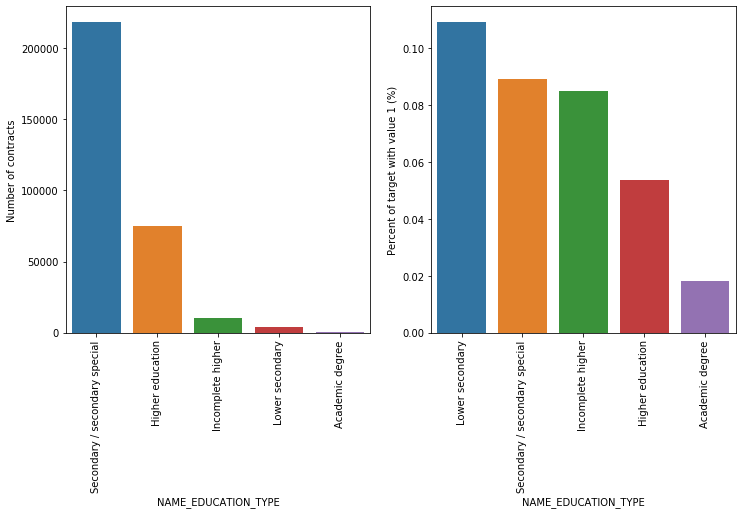

In [21]:
#教育程度
plot_stats('NAME_EDUCATION_TYPE',True)

1. Secondary文化水平的人更容易贷款，且违约率较高。Secondary大约为0.08。    
2. Lower secondary贷款的人很少，这可能是因为由于年龄很低，父母还在负担他们的花销。但其中贷款的人违约率较高，大约为0.11。    
3. 教育程度越高，违约率越低，这符合常理。

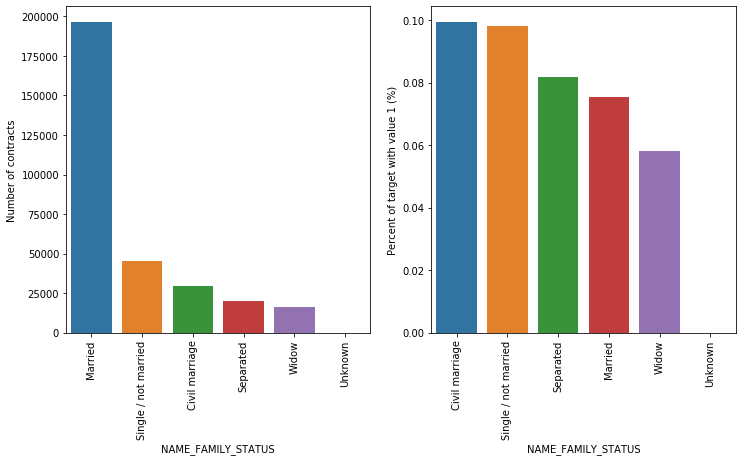

In [22]:
#申请贷款时的家庭情感状况
plot_stats('NAME_FAMILY_STATUS',True,True)

1. 申请贷款的人大部分已经结婚，这类人群的违约率在8%之内，只高于寡居的客户。
2. 世俗结婚（无宗教仪式）和单身的客户违约率比较高。

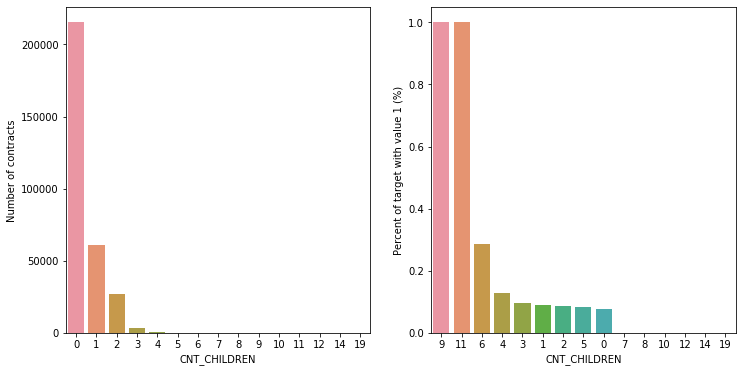

In [23]:
#孩子个数差异
plot_stats('CNT_CHILDREN')

1. 申请贷款的人大多没有孩子，他们的违约率在1%左右； 
2. 家庭里孩子越多违约率越高，发现有9，11个孩子的家庭违约率到达了100%（可能有样本不够的原因

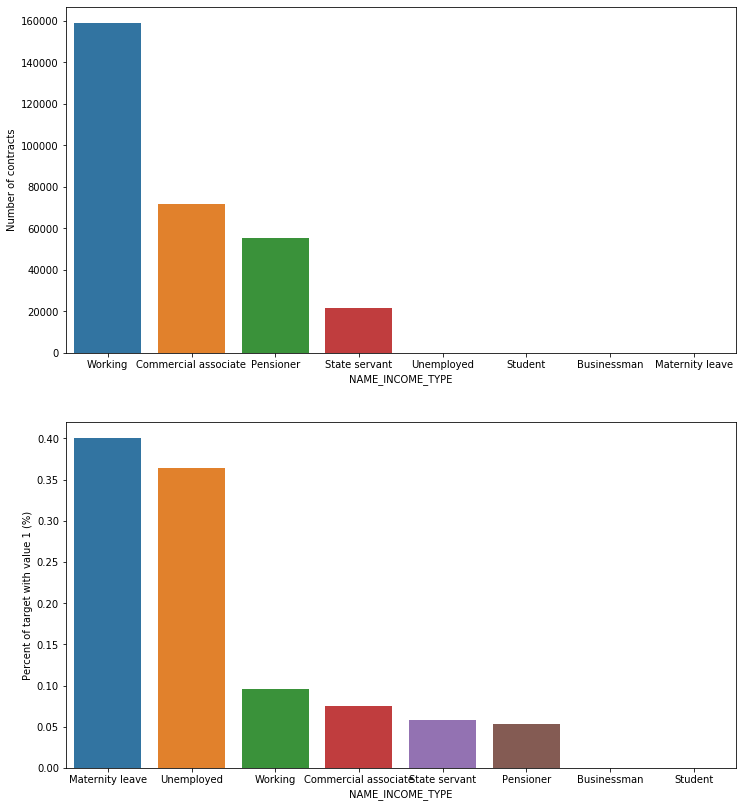

In [24]:
#收入类型差异
plot_stats('NAME_INCOME_TYPE',False,False)

失业和休产假的客户违约率较高，在35%以上，对于这两类人放贷需谨慎

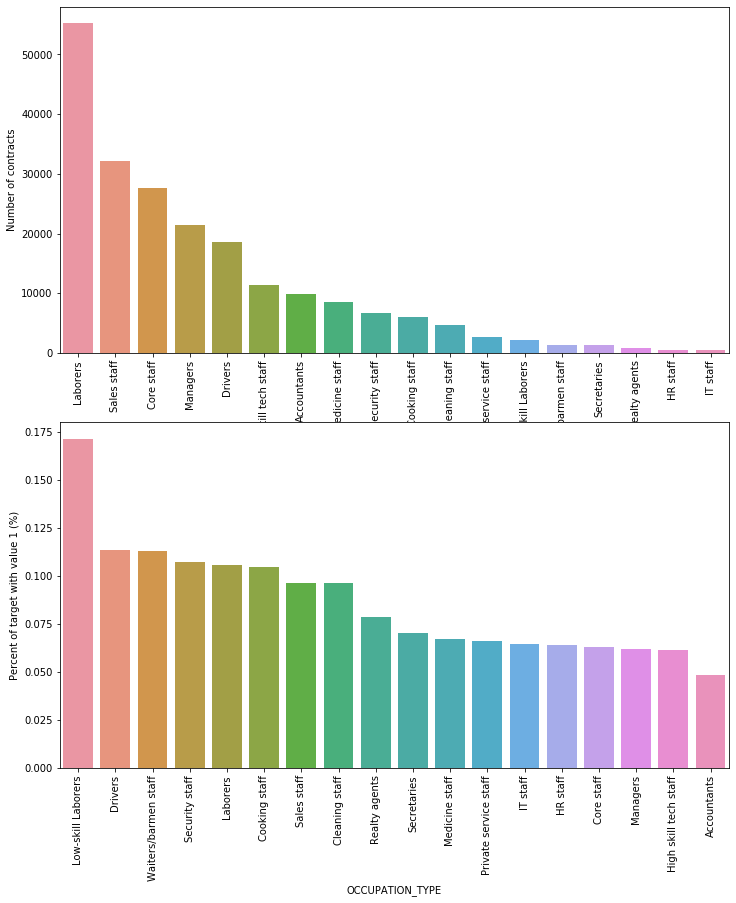

In [26]:
#工作类别差异
plot_stats('OCCUPATION_TYPE',True, False)

申请者从事的越是收入低，不稳定的职业，违约率越高，比如低廉劳动力，司机，服务员，理发师；而像经理、会计、高科技员工这类具有稳定高收入的职业违约率就较低。

## 四、特征工程
   针对主训练集创建几个新的特征。
   - 考虑用户的家庭负担，抚养孩子的花费一般比较大，所以创造一个新的特征：INCOME_PER_CHILD（收入与孩子个数的比值）
   + 考虑用户的还款负担，创造了三个特征：ANNUITY_INCOME_PERCENT（每年应还贷款占收入的百分比）；CREDIT_INCOME_PERCENT（总贷款金额占收入的百分比）；CREDIT_TERM（每年应还贷款占总贷款金额的百分比）
   * 之前我们发现缺失度较高的特征大多为房屋信息，现在根据用户是否缺失房屋信息设置一个二分类特征: HAS_HOUSE_INPORMATION

In [27]:
#拷贝数据
train_data_domain=train_data.copy()
test_data_domain=test_data.copy()
#新建特征
train_data_domain['INCOME_PER_CHILD']=train_data_domain['AMT_INCOME_TOTAL']/train_data_domain['CNT_CHILDREN']
train_data_domain['ANNUITY_INCOME_PERCENT']=train_data_domain['AMT_ANNUITY']/train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['CREDIT_INCOME_PERCENT']=train_data_domain['AMT_CREDIT']/train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['CREDIT_TERM']=train_data_domain['AMT_ANNUITY']/train_data_domain['AMT_CREDIT']
train_data_domain['YEARS_EMPLOYED_PERCENT']=train_data_domain['DAYS_EMPLOYED']/train_data_domain['DAYS_BIRTH']
train_data_domain['HAS_HOUSE_INPORMATION']=train_data_domain['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)

## 五、建模预测
使用lightgbm算法进行建模分析

In [1]:
def model(features,test_features,encoding='ohe',n_folds=5):
    """数据准备"""
    #Extract the ids
    train_ids=features['SK_ID_CURR']
    test_ids=test_features['SK_ID_CURR']
    
    #Extract the labels for training
    labels=features['TARGET']
    
    #Remove the ids and target
    features=features.drop(['SK_ID_CURR','TARGET'],axis=1)
    test_features=test_features.drop('SK_ID_CURR',axis=1)
    
    #One Hot Encoding
    if encoding=='ohe':
        features=pd.get_dummies(features)
        test_features=pd.get_dummies(test_features)
        
        #Align the dataframes by the columns
        features,test_features=features.align(test_features,join='inner',axis=1)
        
        #No categorical indices to record
        cat_indices='auto'
        
    #Integer label encoding
    elif encoding=='le':
        
        #create a label encoder
        label_encoder=LabelEncoder()
        
        #List for storing categorical indices
        cat_indices=[]
        
        #Iterate through each column
        for i,col in enumerate(features):
            if features[col].dtype=='object':
                #Map the categorical features to integers
                features[col]=label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col]=label_encoder.fit_transform(np.array(test_features[col].astype(str)).reshape((-1,)))
                
                #record the categorical indices
                cat_indices.append(i)
        
    #catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le' ")
    
    """输出训练集以及测试集的shape"""
    print('training data shape:',features.shape)
    print('testing data shape:',test_features.shape)
    
    #Extract feature names
    feature_names=list(features.columns)
    
    #Convert to np arrays
    features=np.array(features)
    test_features=np.array(test_features)
        
    #create the Kfold object
    k_fold=KFold(n_splits=n_folds,shuffle=True,random_state=50)
        
    #Empty array for feature importances
    feature_importance_values=np.zeros(len(feature_names))

    #Empty array for test predictions
    test_predictions=np.zeros(test_features.shape[0])
        
    #Empty array for out of fold validation predictions
    out_of_fold=np.zeros(features.shape[0])
        
    #Lists for recording validation and training scores
    valid_scores=[]
    train_scores=[]
    
    """建立模型"""
    #Iterate through each fold
    for train_indices,valid_indices in k_fold.split(features):
            
        #Training data for the fold
        train_features,train_labels=features[train_indices],labels[train_indices]
        #Validation data for the fold
        valid_features,valid_labels=features[valid_indices],labels[valid_indices]
            
        #Create the model
        model=lgb.LGBMClassifier(n_estimators=1000,objective='binary',class_weight='balanced',learning_rate=0.05,
                                 reg_alpha=0.1,reg_lambda=0.1,subsample=0.8,n_jobs=-1,random_state=50)
        
        #Train the model
        model.fit(train_features,train_labels,eval_metric='auc',eval_set=[(valid_features,valid_labels),(train_features,train_labels)],
                 eval_names=['valid','train'],categorical_feature=cat_indices,
                  early_stopping_rounds=100,verbose=200)
        
        #Record the best iteration
        best_iteration=model.best_iteration_
        
        #Record the feature importances
        feature_importance_values+=model.feature_importances_/k_fold.n_splits
        
        #Make predictions
        test_predictions+=model.predict_proba(test_features,num_iteration=best_iteration)[:,1]/k_fold.n_splits
        
        #record the out of fold predictions
        out_of_fold[valid_indices]=model.predict_proba(valid_features,num_iteration=best_iteration)[:,1]
        
        #record the best score
        valid_score=model.best_score_['valid']['auc']
        train_score=model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        #clean up memory
        gc.enable()
        del model,train_features,valid_features
        gc.collect()
     
    """整合要输出的结果"""
    #Make the submission dataframe
    submission=pd.DataFrame({'SK_ID_CURR':test_ids,'TARGET':test_predictions})
    
    #Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [28]:
#对测试集也加入新特征
test_data_domain['INCOME_PER_CHILD']=test_data_domain['AMT_INCOME_TOTAL']/test_data_domain['CNT_CHILDREN']
test_data_domain['ANNUITY_INCOME_PERCENT']=test_data_domain['AMT_ANNUITY']/test_data_domain['AMT_INCOME_TOTAL']
test_data_domain['CREDIT_INCOME_PERCENT']=test_data_domain['AMT_CREDIT']/test_data_domain['AMT_INCOME_TOTAL']
test_data_domain['CREDIT_TERM']=test_data_domain['AMT_ANNUITY']/test_data_domain['AMT_CREDIT']
test_data_domain['YEARS_EMPLOYED_PERCENT']=test_data_domain['DAYS_EMPLOYED']/test_data_domain['DAYS_BIRTH']
test_data_domain['HAS_HOUSE_INPORMATION']=test_data_domain['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)

submission,fi,metrics=model(train_data_domain,test_data_domain)

training data shape: (307511, 247)
testing data shape: (48744, 247)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804589	train's binary_logloss: 0.541612	valid's auc: 0.762351	valid's binary_logloss: 0.557246
[400]	train's auc: 0.834291	train's binary_logloss: 0.511259	valid's auc: 0.763038	valid's binary_logloss: 0.538733
Early stopping, best iteration is:
[411]	train's auc: 0.835869	train's binary_logloss: 0.509525	valid's auc: 0.763095	valid's binary_logloss: 0.537678
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804261	train's binary_logloss: 0.542063	valid's auc: 0.766592	valid's binary_logloss: 0.55745
[400]	train's auc: 0.833776	train's binary_logloss: 0.511592	valid's auc: 0.766682	valid's binary_logloss: 0.539088
Early stopping, best iteration is:
[341]	train's auc: 0.825784	train's binary_logloss: 0.519918	valid's auc: 0.766932	valid's binary_logloss: 0.544046
Training until validation scores don't impr

In [29]:
#输出k-Fold得分情况
print('Baseline metrics')
print(metrics)

del train_data_domain,test_data_domain
gc.collect

Baseline metrics
      fold     train     valid
0        0  0.835869  0.763095
1        1  0.825784  0.766932
2        2  0.812329  0.770227
3        3  0.809244  0.765925
4        4  0.809661  0.764811
5  overall  0.818577  0.766156


<function gc.collect(generation=2)>

In [30]:
#通过lgb自带函数查看特征的重要性
def plot_feature_importances(df):
    
    #Sort features according to importance
    df=df.sort_values('importance',ascending=False).reset_index()
    
    #Normalize the feature importances to add up to one
    df['importance_normalized']=df['importance']/df['importance'].sum()
    
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10,6))
    ax=plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),df['importance_normalized'].head(15),align='center',edgecolor='k')
    
    #set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #plot labeling
    plt.xlabel('Normalized Importance');
    plt.title('Feature Importances')
    plt.show()
    
    return df

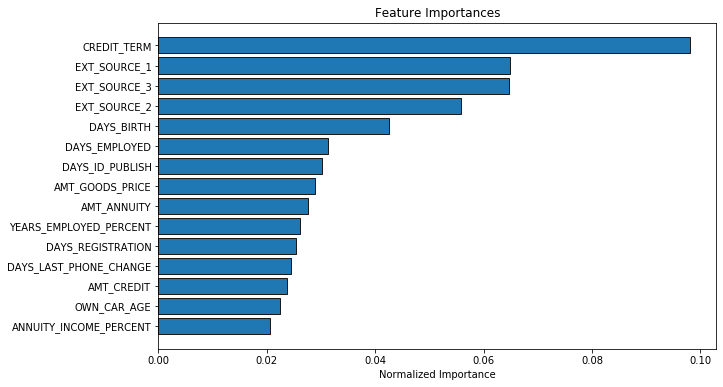

,index,feature,importance,importance_normalized
0,107,CREDIT_TERM,858.4,0.098058
1,27,EXT_SOURCE_1,567.4,0.064816
2,29,EXT_SOURCE_3,567.0,0.064770
3,28,EXT_SOURCE_2,489.4,0.055906
4,6,DAYS_BIRTH,372.0,0.042495
...,...,...,...,...
242,129,NAME_INCOME_TYPE_Student,0.0,0.000000
243,95,FLAG_DOCUMENT_19,0.0,0.000000
244,96,FLAG_DOCUMENT_20,0.0,0.000000
245,222,ORGANIZATION_TYPE_Trade: type 5,0.0,0.000000


In [31]:
plot_feature_importances(fi)

## 六、利用辅助训练集
### 1.信用局信息

In [32]:
bureau=pd.read_csv(r'E:\machine learning\信用风险数据集\bureau.csv')


In [33]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


一个人可能在多个Bureau有贷款记录，贷款记录越多是不是意味着信用越好？现在来统计一下每个客户的在其他信用局的贷款数量，然后将其合并到训练集中。

In [34]:
previous_loan_counts=bureau.groupby('SK_ID_CURR',as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU':'previous_loan_counts'})
previous_loan_counts.head(10)

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
5,100007,1
6,100008,3
7,100009,18
8,100010,2
9,100011,4


由于可能存在客户在其他信用局无贷款记录，因此合并之后将缺失值设置为0。

In [35]:
#add it to train data
train_data=train_data.merge(previous_loan_counts,on='SK_ID_CURR',how='left')
#fill the missing values with 0
train_data['previous_loan_counts']=train_data['previous_loan_counts'].fillna(0)
train_data['previous_loan_counts'].describe()

count    307511.000000
mean          4.765114
std           4.496199
min           0.000000
25%           1.000000
50%           4.000000
75%           7.000000
max         116.000000
Name: previous_loan_counts, dtype: float64

In [36]:
#观察该特征的在违约用户和非违约用户中的分布情况
def kde_target(var_name,df):
    
    #Calculate the correlation coefficient between the new variable and the target
    corr=df['TARGET'].corr(df[var_name])
    
    #Calculate medians for repaid vs not repaid
    avg_repaid=df.loc[df['TARGET']==0,var_name].mean()
    avg_not_repaid=df.loc[df['TARGET']==1,var_name].mean()
    
    #plot
    plt.figure(figsize=(12,8))
    sns.kdeplot(df.loc[df['TARGET']==0,var_name],label='Target==0')
    sns.kdeplot(df.loc[df['TARGET']==1,var_name],label='Target==1')
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('Distribution of %s' % var_name)
    plt.legend()
    
    #print out the corr
    print('The correlation between %s and the TARGET is %0.4f' % (var_name,corr))
    #print out average values
    print('Median value for loan that was not repaid= %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid= %0.4f' % avg_repaid)


The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid= 4.6131
Median value for loan that was repaid= 4.7785


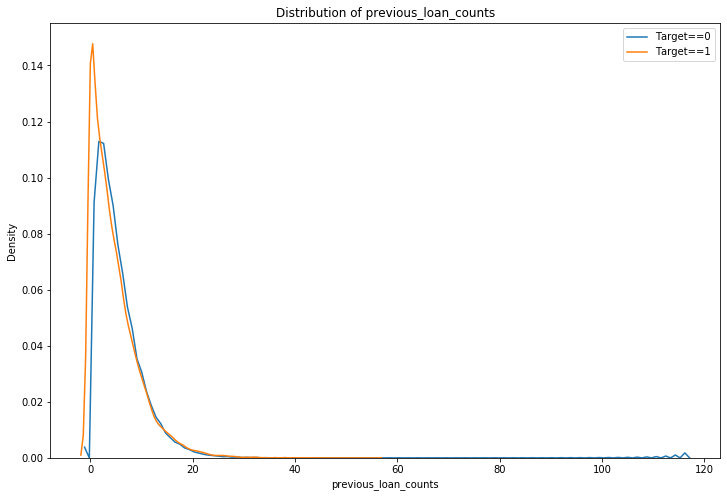

In [37]:
kde_target('previous_loan_counts',train_data)

可以看到贷款数量与是否违约的相关程度不高，但我们并不将它删除。

#### 连续型变量特征扩增及提取

In [38]:
#连续型变量特征扩增
def agg_numeric(df, group_var, df_name):
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    """利用连续型变量的统计值扩增特征"""
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]
    
    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg


In [39]:
bureau_agg=agg_numeric(bureau,group_var='SK_ID_CURR',df_name='bureau')
bureau_agg.head()

D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [40]:
#合并到主训练集
train_data=train_data.merge(bureau_agg,on='SK_ID_CURR',how='left')
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [41]:
#计算相关系数来看一下这些特征与预测值的相关程度
def cal_corrs(main,assist):
    new_corrs=[]
    #extract the columns
    columns=assist.columns
    #Iteration through the columns
    for col in columns:
        #Calculate correlation with the target
        corr=main['TARGET'].corr(main[col])
        new_corrs.append((col,corr))
    
    #order the corrs
    new_corrs=sorted(new_corrs,key=lambda x: abs(x[1]) ,reverse=True)
    return new_corrs[:20]

In [42]:
bureau_corrs=cal_corrs(train_data,bureau_agg)
bureau_corrs

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161599),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325547),
 ('bureau_DAYS_CREDIT_UPDATE_max', 0.028233546896535826),
 ('bureau_AMT_CREDIT_SUM_mean', -0.019956561902304607),
 ('bureau_AMT_CREDIT_SUM_max', -0.019737496507844

相关性最高的是bureau_DAYS_CREDIT_mean，结合官方说明文档，这个特征表示的是申请人在信用局开户的平均历史天数。相关系数为正数，表明其与Y值正相关，即开户时间越长的客户，越不容易违约（数据集中天数为负数）。

#### 离散型变量扩充及提取


In [43]:
#离散型变量提取
def count_categorical(df,group_var,df_name):
    
    categorical=pd.get_dummies(df.select_dtypes('object'))
    
    #make sure to put the identifying id on the column
    categorical[group_var]=df[group_var]
    
    #Groupby the group_var and calculate the mean and sum
    categorical=categorical.groupby(group_var).agg(['mean','sum'])
    
    columns=[]
    #Iterate through the variables names
    for var in categorical.columns.levels[0]:
        if var!=group_var:
            for stat in ['count','count_norm']:
                columns.append('%s_%s_%s' % (df_name,var,stat))
            
    categorical.columns=columns
    
    return categorical

In [44]:
bureau_counts=count_categorical(bureau,group_var="SK_ID_CURR",df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.428571,3,0.0,0,0.571429,4,0.0,0,1.0,7,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100002,0.250000,2,0.0,0,0.750000,6,0.0,0,1.0,8,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100003,0.250000,1,0.0,0,0.750000,3,0.0,0,1.0,4,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100004,0.000000,0,0.0,0,1.000000,2,0.0,0,1.0,2,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100005,0.666667,2,0.0,0,0.333333,1,0.0,0,1.0,3,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


In [45]:
#合并到主训练集
train_data=train_data.merge(bureau_counts,on="SK_ID_CURR",how='left')

### 2.Home credit 贷款信息

In [46]:
#导入数据
previous_application=pd.read_csv(r'E:\machine learning\信用风险数据集\previous_application.csv')
POS_CASH_balance=pd.read_csv(r'E:\machine learning\信用风险数据集\POS_CASH_balance.csv')
credit_card_balance=pd.read_csv(r'E:\machine learning\信用风险数据集\credit_card_balance.csv')
installments_payments=pd.read_csv(r'E:\machine learning\信用风险数据集\installments_payments.csv')

#### 连续型变量特征扩增及提取

In [47]:
previous_application_agg=agg_numeric(previous_application,group_var='SK_ID_CURR',df_name='prev_app')
previous_application_agg.head()

D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,prev_app_AMT_ANNUITY_count,prev_app_AMT_ANNUITY_mean,prev_app_AMT_ANNUITY_max,prev_app_AMT_ANNUITY_min,prev_app_AMT_ANNUITY_sum,prev_app_AMT_APPLICATION_count,prev_app_AMT_APPLICATION_mean,prev_app_AMT_APPLICATION_max,prev_app_AMT_APPLICATION_min,...,prev_app_DAYS_TERMINATION_count,prev_app_DAYS_TERMINATION_mean,prev_app_DAYS_TERMINATION_max,prev_app_DAYS_TERMINATION_min,prev_app_DAYS_TERMINATION_sum,prev_app_NFLAG_INSURED_ON_APPROVAL_count,prev_app_NFLAG_INSURED_ON_APPROVAL_mean,prev_app_NFLAG_INSURED_ON_APPROVAL_max,prev_app_NFLAG_INSURED_ON_APPROVAL_min,prev_app_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [48]:
POS_CASH_balance_agg=agg_numeric(POS_CASH_balance,group_var='SK_ID_CURR',df_name='POS_CASH')
POS_CASH_balance_agg.head()

D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,POS_CASH_MONTHS_BALANCE_count,POS_CASH_MONTHS_BALANCE_mean,POS_CASH_MONTHS_BALANCE_max,POS_CASH_MONTHS_BALANCE_min,POS_CASH_MONTHS_BALANCE_sum,POS_CASH_CNT_INSTALMENT_count,POS_CASH_CNT_INSTALMENT_mean,POS_CASH_CNT_INSTALMENT_max,POS_CASH_CNT_INSTALMENT_min,...,POS_CASH_SK_DPD_count,POS_CASH_SK_DPD_mean,POS_CASH_SK_DPD_max,POS_CASH_SK_DPD_min,POS_CASH_SK_DPD_sum,POS_CASH_SK_DPD_DEF_count,POS_CASH_SK_DPD_DEF_mean,POS_CASH_SK_DPD_DEF_max,POS_CASH_SK_DPD_DEF_min,POS_CASH_SK_DPD_DEF_sum
0,100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,...,9,0.777778,7,0,7,9,0.777778,7,0,7
1,100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,...,19,0.000000,0,0,0,19,0.000000,0,0,0
2,100003,28,-43.785714,-18,-77,-1226,28,10.107143,12.0,6.0,...,28,0.000000,0,0,0,28,0.000000,0,0,0
3,100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,...,4,0.000000,0,0,0,4,0.000000,0,0,0
4,100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,...,11,0.000000,0,0,0,11,0.000000,0,0,0


In [49]:
credit_card_balance_agg=agg_numeric(credit_card_balance,group_var='SK_ID_CURR',df_name='Credit_card_balance')
credit_card_balance_agg.head()

D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,Credit_card_balance_MONTHS_BALANCE_count,Credit_card_balance_MONTHS_BALANCE_mean,Credit_card_balance_MONTHS_BALANCE_max,Credit_card_balance_MONTHS_BALANCE_min,Credit_card_balance_MONTHS_BALANCE_sum,Credit_card_balance_AMT_BALANCE_count,Credit_card_balance_AMT_BALANCE_mean,Credit_card_balance_AMT_BALANCE_max,Credit_card_balance_AMT_BALANCE_min,...,Credit_card_balance_SK_DPD_count,Credit_card_balance_SK_DPD_mean,Credit_card_balance_SK_DPD_max,Credit_card_balance_SK_DPD_min,Credit_card_balance_SK_DPD_sum,Credit_card_balance_SK_DPD_DEF_count,Credit_card_balance_SK_DPD_DEF_mean,Credit_card_balance_SK_DPD_DEF_max,Credit_card_balance_SK_DPD_DEF_min,Credit_card_balance_SK_DPD_DEF_sum
0,100006,6,-3.5,-1,-6,-21,6,0.000000,0.00,0.0,...,6,0.000000,0,0,0,6,0.000000,0,0,0
1,100011,74,-38.5,-2,-75,-2849,74,54482.111149,189000.00,0.0,...,74,0.000000,0,0,0,74,0.000000,0,0,0
2,100013,96,-48.5,-1,-96,-4656,96,18159.919219,161420.22,0.0,...,96,0.010417,1,0,1,96,0.010417,1,0,1
3,100021,17,-10.0,-2,-18,-170,17,0.000000,0.00,0.0,...,17,0.000000,0,0,0,17,0.000000,0,0,0
4,100023,8,-7.5,-4,-11,-60,8,0.000000,0.00,0.0,...,8,0.000000,0,0,0,8,0.000000,0,0,0


In [50]:
installments_payments_agg=agg_numeric(installments_payments,group_var='SK_ID_CURR',df_name='installments_payments')
installments_payments_agg.head()

,SK_ID_CURR,installments_payments_NUM_INSTALMENT_VERSION_count,installments_payments_NUM_INSTALMENT_VERSION_mean,installments_payments_NUM_INSTALMENT_VERSION_max,installments_payments_NUM_INSTALMENT_VERSION_min,installments_payments_NUM_INSTALMENT_VERSION_sum,installments_payments_NUM_INSTALMENT_NUMBER_count,installments_payments_NUM_INSTALMENT_NUMBER_mean,installments_payments_NUM_INSTALMENT_NUMBER_max,installments_payments_NUM_INSTALMENT_NUMBER_min,...,installments_payments_AMT_INSTALMENT_count,installments_payments_AMT_INSTALMENT_mean,installments_payments_AMT_INSTALMENT_max,installments_payments_AMT_INSTALMENT_min,installments_payments_AMT_INSTALMENT_sum,installments_payments_AMT_PAYMENT_count,installments_payments_AMT_PAYMENT_mean,installments_payments_AMT_PAYMENT_max,installments_payments_AMT_PAYMENT_min,installments_payments_AMT_PAYMENT_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,7,5885.132143,17397.900,3951.000,41195.925,7,5885.132143,17397.900,3951.000,41195.925
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,19,11559.247105,53093.745,9251.775,219625.695,19,11559.247105,53093.745,9251.775,219625.695
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,25,64754.586000,560835.360,6662.970,1618864.650,25,64754.586000,560835.360,6662.970,1618864.650
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,3,7096.155000,10573.965,5357.250,21288.465,3,7096.155000,10573.965,5357.250,21288.465
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,9,6240.205000,17656.245,4813.200,56161.845,9,6240.205000,17656.245,4813.200,56161.845


In [52]:
#合并到主训练集中
train_data=train_data.merge(installments_payments_agg,on="SK_ID_CURR",how='left')

In [53]:
train_data=train_data.merge(POS_CASH_balance_agg,on="SK_ID_CURR",how='left')
train_data=train_data.merge(previous_application_agg,on="SK_ID_CURR",how='left')
train_data=train_data.merge(credit_card_balance_agg,on="SK_ID_CURR",how='left')

In [54]:
#分别分析这几个数据集与Y变量的相关程度
previous_corrs=cal_corrs(train_data,previous_application_agg)
previous_corrs

[('prev_app_DAYS_DECISION_min', 0.05343369406767517),
 ('prev_app_DAYS_FIRST_DRAWING_mean', -0.048802580346264855),
 ('prev_app_DAYS_DECISION_mean', 0.04686436759886143),
 ('prev_app_DAYS_FIRST_DRAWING_min', -0.04464250985551034),
 ('prev_app_RATE_DOWN_PAYMENT_sum', -0.041693216775152954),
 ('prev_app_DAYS_FIRST_DRAWING_sum', -0.041671148719533244),
 ('prev_app_RATE_DOWN_PAYMENT_max', -0.040095821450583935),
 ('prev_app_HOUR_APPR_PROCESS_START_mean', -0.03592713211133655),
 ('prev_app_AMT_ANNUITY_mean', -0.034870773323147065),
 ('prev_app_RATE_DOWN_PAYMENT_mean', -0.03360081670244196),
 ('prev_app_AMT_ANNUITY_min', -0.03224862867170919),
 ('prev_app_DAYS_FIRST_DRAWING_count', -0.03183327162711633),
 ('prev_app_DAYS_FIRST_DUE_count', -0.03183327162711633),
 ('prev_app_DAYS_LAST_DUE_1ST_VERSION_count', -0.03183327162711633),
 ('prev_app_DAYS_LAST_DUE_count', -0.03183327162711633),
 ('prev_app_DAYS_TERMINATION_count', -0.03183327162711633),
 ('prev_app_NFLAG_INSURED_ON_APPROVAL_count', -0

 相关性最高的特征是prev_app_DAYS_DECISION_min，结合官方文档说明，该特征表示当前贷款申请与先前贷款申请之间的最短天数。相关系数为正值，表示两次贷款申请之间的天数越小，越容易违约。

D:\software\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\software\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


The correlation between prev_app_DAYS_DECISION_min and the TARGET is 0.0534
Median value for loan that was not repaid= -1385.1573
Median value for loan that was repaid= -1553.6238


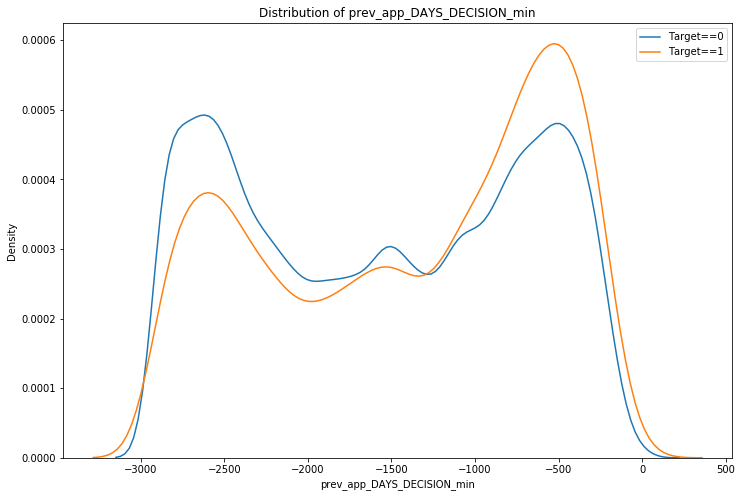

In [58]:
kde_target('prev_app_DAYS_DECISION_min',train_data)

由于相关系数接近于0，从图中可以看到区分度并不是很明显。

In [55]:
credit_card_corrs=cal_corrs(train_data,credit_card_balance_agg)
credit_card_corrs

[('Credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean', 0.10769248655857967),
 ('Credit_card_balance_CNT_DRAWINGS_CURRENT_max', 0.10138934542007788),
 ('Credit_card_balance_AMT_BALANCE_mean', 0.08717722087276902),
 ('Credit_card_balance_AMT_TOTAL_RECEIVABLE_mean', 0.08648989773622691),
 ('Credit_card_balance_AMT_RECIVABLE_mean', 0.08647754856243817),
 ('Credit_card_balance_AMT_RECEIVABLE_PRINCIPAL_mean', 0.08606238066824756),
 ('Credit_card_balance_CNT_DRAWINGS_CURRENT_mean', 0.0825201447910742),
 ('Credit_card_balance_AMT_INST_MIN_REGULARITY_mean', 0.07372405288977363),
 ('Credit_card_balance_CNT_DRAWINGS_POS_CURRENT_max', 0.06894158723256834),
 ('Credit_card_balance_AMT_BALANCE_max', 0.06879775473341647),
 ('Credit_card_balance_AMT_TOTAL_RECEIVABLE_max', 0.06808135726654198),
 ('Credit_card_balance_AMT_RECIVABLE_max', 0.068066450927403),
 ('Credit_card_balance_AMT_RECEIVABLE_PRINCIPAL_max', 0.06691923575784701),
 ('Credit_card_balance_AMT_BALANCE_min', 0.06416309650921947),
 ('Credit_

相关性较高的特征有两个，第一个是：Credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean，结合官方文档说明，表示的是本月在ATM机上取款次数的平均值，相关系数为正，表示取款次数越多越容易违约。
第二个是Credit_card_balance_CNT_DRAWINGS_CURRENT_max，结合官方文档说明，表示的是本月取款次数的最大值。相关系数为正，表示取款次数越多越容易违约。

The correlation between Credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean and the TARGET is 0.1077
Median value for loan that was not repaid= 0.8500
Median value for loan that was repaid= 0.5346


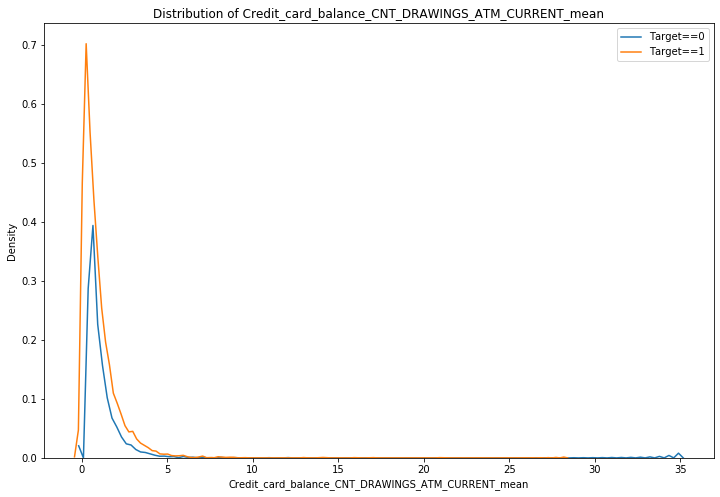

In [59]:
kde_target('Credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean',train_data)

The correlation between Credit_card_balance_CNT_DRAWINGS_CURRENT_max and the TARGET is 0.1014
Median value for loan that was not repaid= 10.2829
Median value for loan that was repaid= 6.4734


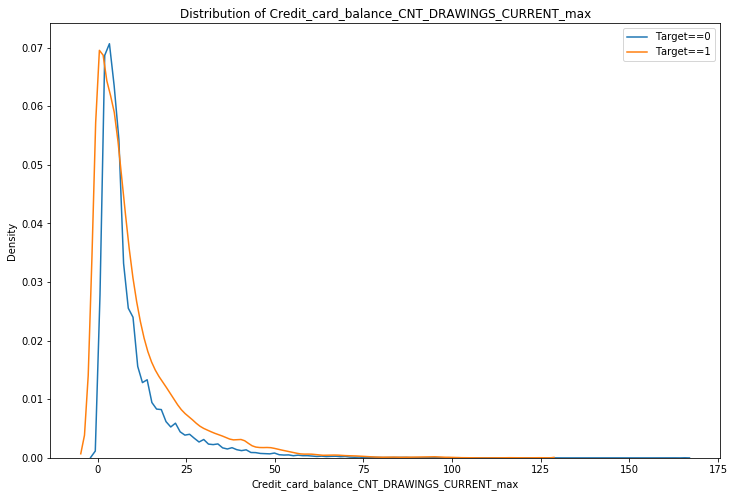

In [60]:
kde_target('Credit_card_balance_CNT_DRAWINGS_CURRENT_max',train_data)

In [61]:
POS_CASH_corrs=cal_corrs(train_data,POS_CASH_balance_agg)
POS_CASH_corrs

[('POS_CASH_MONTHS_BALANCE_min', 0.05530732656409677),
 ('POS_CASH_MONTHS_BALANCE_sum', 0.04057046526766646),
 ('POS_CASH_CNT_INSTALMENT_FUTURE_count', -0.035807397044514376),
 ('POS_CASH_CNT_INSTALMENT_count', -0.03580217099626764),
 ('POS_CASH_MONTHS_BALANCE_count', -0.03563197385243204),
 ('POS_CASH_SK_DPD_count', -0.03563197385243204),
 ('POS_CASH_SK_DPD_DEF_count', -0.03563197385243204),
 ('POS_CASH_MONTHS_BALANCE_mean', 0.03454271412780029),
 ('POS_CASH_CNT_INSTALMENT_FUTURE_mean', 0.02782684587947424),
 ('POS_CASH_CNT_INSTALMENT_min', 0.01983967245358912),
 ('POS_CASH_CNT_INSTALMENT_FUTURE_min', 0.019010274379881537),
 ('POS_CASH_CNT_INSTALMENT_mean', 0.018065948360827176),
 ('POS_CASH_CNT_INSTALMENT_sum', -0.014669822945159165),
 ('POS_CASH_CNT_INSTALMENT_FUTURE_max', 0.013323668287264641),
 ('POS_CASH_CNT_INSTALMENT_max', 0.01329567798988022),
 ('POS_CASH_SK_DPD_DEF_max', 0.009580178927930609),
 ('POS_CASH_SK_DPD_DEF_mean', 0.006495583572051335),
 ('POS_CASH_CNT_INSTALMENT_FUT

In [57]:
install_corrs=cal_corrs(train_data,installments_payments_agg)
install_corrs

[('installments_payments_DAYS_ENTRY_PAYMENT_min', 0.05879421349234481),
 ('installments_payments_DAYS_INSTALMENT_min', 0.0586483928504767),
 ('installments_payments_DAYS_ENTRY_PAYMENT_mean', 0.04399223294529965),
 ('installments_payments_DAYS_INSTALMENT_mean', 0.0435093552703462),
 ('installments_payments_DAYS_ENTRY_PAYMENT_sum', 0.03522682547142305),
 ('installments_payments_DAYS_INSTALMENT_sum', 0.03506438257552748),
 ('installments_payments_NUM_INSTALMENT_VERSION_min', -0.03203932617574992),
 ('installments_payments_NUM_INSTALMENT_VERSION_sum', -0.03006267382058375),
 ('installments_payments_NUM_INSTALMENT_VERSION_mean', -0.027322629780943426),
 ('installments_payments_AMT_PAYMENT_min', -0.025724422843114606),
 ('installments_payments_AMT_PAYMENT_sum', -0.024375335620265757),
 ('installments_payments_AMT_PAYMENT_mean', -0.023168871269153724),
 ('installments_payments_DAYS_ENTRY_PAYMENT_count', -0.021217130112504885),
 ('installments_payments_AMT_PAYMENT_count', -0.021217130112504885

相关性最高的特征是installments_payments_DAYS_ENTRY_PAYMENT_min，结合官方文档说明，表示的是前一期贷款与当期贷款截止日期之间的天数。相关系数为正，表示时间间隔越短，客户越容易违约。

The correlation between installments_payments_DAYS_ENTRY_PAYMENT_min and the TARGET is 0.0588
Median value for loan that was not repaid= -1417.3352
Median value for loan that was repaid= -1612.9708


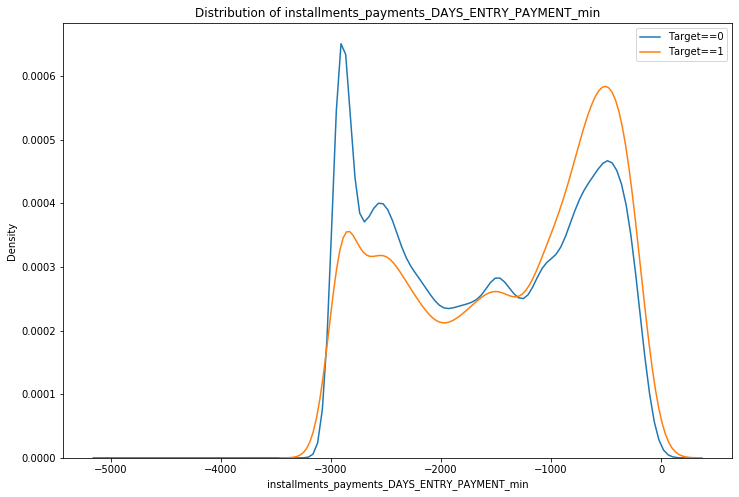

In [62]:
kde_target('installments_payments_DAYS_ENTRY_PAYMENT_min',train_data)

#### 离散型变量提取

In [64]:
#提取
POS_CASH_balance_counts=count_categorical(POS_CASH_balance,group_var='SK_ID_CURR',df_name='POS_CASH')
credit_card_balance_counts=count_categorical(credit_card_balance,group_var='SK_ID_CURR',df_name='Credit_card_balance')
previous_application_counts=count_categorical(previous_application,group_var='SK_ID_CURR',df_name='prev_app')

In [65]:
#合并至训练集
train_data=train_data.merge(POS_CASH_balance_counts,on="SK_ID_CURR",how='left')
train_data=train_data.merge(credit_card_balance_counts,on="SK_ID_CURR",how='left')
train_data=train_data.merge(previous_application_counts,on="SK_ID_CURR",how='left')

### 3.特征选择


In [66]:
#将加工后的辅助训练集加入到测试集中

#连续型变量
test_data=test_data.merge(POS_CASH_balance_agg,on="SK_ID_CURR",how='left')
test_data=test_data.merge(previous_application_agg,on="SK_ID_CURR",how='left')
test_data=test_data.merge(credit_card_balance_agg,on="SK_ID_CURR",how='left')
test_data=test_data.merge(installments_payments_agg,on="SK_ID_CURR",how='left')
#离散型变量
test_data=test_data.merge(POS_CASH_balance_counts,on="SK_ID_CURR",how='left')
test_data=test_data.merge(credit_card_balance_counts,on="SK_ID_CURR",how='left')
test_data=test_data.merge(previous_application_counts,on="SK_ID_CURR",how='left')

In [71]:
test_data=test_data.merge(bureau_agg,on="SK_ID_CURR",how='left')
test_data=test_data.merge(bureau_counts,on="SK_ID_CURR",how='left')

In [67]:
#将特征工程中新建的变量加入到训练集中
train_data['INCOME_PER_CHILD']=train_data['AMT_INCOME_TOTAL']/train_data['CNT_CHILDREN']
train_data['ANNUITY_INCOME_PERCENT']=train_data['AMT_ANNUITY']/train_data['AMT_INCOME_TOTAL']
train_data['CREDIT_INCOME_PERCENT']=train_data['AMT_CREDIT']/train_data['AMT_INCOME_TOTAL']
train_data['CREDIT_TERM']=train_data['AMT_ANNUITY']/train_data['AMT_CREDIT']
train_data['YEARS_EMPLOYED_PERCENT']=train_data['DAYS_EMPLOYED']/train_data['DAYS_BIRTH']
train_data['HAS_HOUSE_INPORMATION']=train_data['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)
#加入到测试集中
test_data['INCOME_PER_CHILD']=test_data['AMT_INCOME_TOTAL']/test_data['CNT_CHILDREN']
test_data['ANNUITY_INCOME_PERCENT']=test_data['AMT_ANNUITY']/test_data['AMT_INCOME_TOTAL']
test_data['CREDIT_INCOME_PERCENT']=test_data['AMT_CREDIT']/test_data['AMT_INCOME_TOTAL']
test_data['CREDIT_TERM']=test_data['AMT_ANNUITY']/test_data['AMT_CREDIT']
test_data['YEARS_EMPLOYED_PERCENT']=test_data['DAYS_EMPLOYED']/test_data['DAYS_BIRTH']
test_data['HAS_HOUSE_INPORMATION']=test_data['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)

In [72]:
print('shape of training data: {}'.format(train_data.shape));
print('shape of testing data: {}'.format(test_data.shape));

shape of training data: (307511, 803)
shape of testing data: (48744, 801)


经过对辅助训练集进行特征提取后，特征数量大幅增加。此时我们通过计算变量之间的相关系数，删除一部分相关程度较高的变量。

In [73]:
#计算相关系数

#calculate the corrs
corrs=train_data.corr()

#set the thresholds
threshold=0.8

#Empty dictionary to hold correlated variables
above_threshold_vars={}

#For each column,record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col]=list(corrs.index[corrs[col]>threshold])
    
#生成要删除的变量列表

#Track columns to remove and columns already examined
cols_to_remove=[]
cols_seen=[]
cols_to_remove_pair=[]

#Iterate through columns and correlated columns
for key,value in above_threshold_vars.items():
    #keep track of columns already examined
    cols_seen.append(key)
    
    for x in value:
        if x==key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

cols_to_remove=list(set(cols_to_remove))
print('Number of columns to remove:',len(cols_to_remove))

Number of columns to remove: 298


In [74]:
#delete the columns
train_data_removed=train_data.drop(columns=cols_to_remove)
test_data_removed=test_data.drop(columns=cols_to_remove)

In [76]:
train_data_removed.shape

(307511, 505)

### 4.建模预测

In [77]:
submission_2, fi_2, metrics_2 = model(train_data_removed, test_data_removed)

training data shape: (307511, 623)
testing data shape: (48744, 623)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.827639	train's binary_logloss: 0.518138	valid's auc: 0.781729	valid's binary_logloss: 0.535743
[400]	train's auc: 0.8628	train's binary_logloss: 0.479093	valid's auc: 0.782345	valid's binary_logloss: 0.511087
Early stopping, best iteration is:
[324]	train's auc: 0.850956	train's binary_logloss: 0.492462	valid's auc: 0.782834	valid's binary_logloss: 0.51958
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.827854	train's binary_logloss: 0.517789	valid's auc: 0.780594	valid's binary_logloss: 0.53593
[400]	train's auc: 0.862817	train's binary_logloss: 0.479009	valid's auc: 0.781347	valid's binary_logloss: 0.511563
Early stopping, best iteration is:
[361]	train's auc: 0.856962	train's binary_logloss: 0.48555	valid's auc: 0.781491	valid's binary_logloss: 0.515739
Training until validation scores don't improve 

In [79]:
print(metrics_2)

      fold     train     valid
0        0  0.850956  0.782834
1        1  0.856962  0.781491
2        2  0.857277  0.784779
3        3  0.860193  0.783649
4        4  0.879878  0.779802
5  overall  0.861053  0.782381


## 七、结论
1. 经过对主训练集数据可视化的探索，发现以下现象：
   - 女性违约率低于男性
   + 随着年龄的增加，客户的违约率在降低
   * 是否拥有房或车不是影响客户违约率的效果不明显。
   - 教育程度越高，违约率越低；具有稳定高收入的职业违约率就较低。
   + 失业及休产假的客户违约率在35%以上，放贷需谨慎。
2. 利用辅助训练集后，运用lightgbm算法进行建模预测，在测试集上的得分为0.768。